In [ ]:
import numpy as np
from PIL import Image
from pathlib import Path
from skimage import io
import matplotlib.pyplot as plt
from skimage.io import imsave, imread
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


This notebook takes hyperspectral Images (.tiff stacks) and performs PCA on them, adapted from hyperspectral_pca_refactored.ipynb.  This workbook is used to analyze the data from the brookhaven xpeem experiments.  

In [ ]:

#Function to perform and plot PCA by calculating the covariance matrix then decomposing
#similar to sklearn.decomposition.PCA 
def perform_pca(filename,energy_range=[0,1],mean_centered=False, scree_plot=True):

    """This function reads a tiff stack from filename and peforms PCA using SVD.  It returns the Eigenvalues and the Eigenvectors (eigenspectra)
    energy_range tells the function what energy range to plot the spectra over.  mean_centered will subtract the mean spectra, visualize will plot the eigenvalues.  
    """
    
    #Read the tif stack and form a flattened array with the shape [spectrum, pixel]
    image = io.imread(str(filename))
    print(image.shape)
    flattened = np.reshape(image,(image.shape[0],image.shape[1]*image.shape[2]))

    #normalize by the max value of the intensity image
    normalized_data = np.zeros(flattened.shape)
    mins = np.min(flattened, axis=0)
    maxs = np.max(flattened, axis=0)
    for pixel in range(flattened.shape[1]):
        #Account for bad scans that would result in divide by zero errors
        spectrumrange = (maxs[pixel]-mins[pixel])
        if spectrumrange <0.001: spectrumrange=1

        #normalize the data from [0,1]
        normalized = (flattened[:,pixel]-mins[pixel])/spectrumrange
        normalized_data[:,pixel] = normalized

    #Optionally mean center the spectra by subtracting the mean spectra from each individual pixel spectra
    mean_spectra = np.mean(normalized_data, axis=1)
    if mean_centered:
        for column in range(normalized_data.shape[1]):
            normalized_data[:,column] = np.subtract(normalized_data[:,column],mean_spectra)
    
    #Plot the mean spectra
    xrange = np.linspace(energy_range[0],energy_range[1],len(mean_spectra))
    plt.title("Mean Spectra")
    plt.plot(xrange,mean_spectra)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Intensity (arb. u.)")
    reshaped = np.reshape(flattened[0,:],(image.shape[1],image.shape[2]))
    #plt.imshow(reshaped)
    plt.show()
    
    #Perform PCA by calculating the covariance and then taking the singular variable decomposition of the covariance matrix
    covariance = np.cov(normalized_data)
    (u, s, vh) = np.linalg.svd(covariance)

    #plot the eigenvalues if visualize is set to true
    if scree_plot:
        plt.title("Cumulative Variance")
        plt.xlabel("Component number")
        plt.xticks(np.arange(1,11,1))
        plt.ylabel("Cumulative variance")
        plt.scatter(np.arange(1,11,1),np.cumsum(s[0:10])/s.sum())

        plt.show()

    return (u,s,vh)

#plotting function for the PCA results
def get_pca_info(results, target_variance = 0.95, max_plotted=3,energy_range=[0,1],xlabel=""):

    """This function takes the results from perform_pca() in the format (eigenspectra, eigenvalues, extra information), and plots each 
    eigenspectra up to the significance limit.  
    The significance limit is determined by the cumulative sum of the eigenvalues up to a target, target_variance.  
    max_plotted also limits the number plotted for cleanliness, and energy_range determines what the units of the spectra plot are"""

    u = results[0]
    s = results[1]
    print("target = " + str(target_variance) + " of total data variance: ", np.sum(s)*target_variance)
    critical = next(x for x, val in enumerate(np.cumsum(s)) if val > np.sum(s)*target_variance)
    print("Critical value: ", critical)

    labels = []
    xrange = np.linspace(energy_range[0],energy_range[1],len(u[:,0]))
    for i in range(critical+1):
        if i>max_plotted:
            break
        labels.append(("PC"+ str(i+1)))
        plt.plot(xrange,u[:,i])
    if xlabel: plt.xlabel(xlabel)
    plt.ylabel("Eigenector loading (arb. u.)")
    plt.legend(labels)
    plt.show()

#plotting function to plot the PCA results 
def get_pca_score_image(imname,u,num_components=10,imprefix="PCA Score "):
    """This function takes the dot product of the eigenvectors with the hyperspectral image to give a score for each significant eigenvector (eigenspectra). Images are saved in the current directory
    imname is the image name, u is the matrix of eigenvectors, num_components is how many components to save, and imprefix changes the name of the image and also can change where the image is saved.  
    This takes in the matrix of eigenvectors u, the name of an input image, and the number of components"""
    image = io.imread(imname)
    flattened = np.reshape(image,(image.shape[0],image.shape[1]*image.shape[2]))

    pca_scores = np.dot(flattened.T,u[:,0:num_components])
    print(pca_scores.shape)

    for i in range(num_components):
        print(i)
        currentscores = (np.reshape(pca_scores[:,i],(image.shape[1],image.shape[2]))-np.min(pca_scores[:,i]))/(np.max(pca_scores[:,i]-np.min(pca_scores[:,i])))
        imsave(imprefix+"_"+str(i+1)+".png",currentscores)

    return pca_scores


The following cells are all performing PCA on different images with different settings

In [19]:
cr5_ox2_ni = '/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Oxidation XAS mapping/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p_oxidation2_region2.tif'
cr5_ox1_ni = '/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Oxidation XAS mapping/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p_oxidation1_region2.tif'

cr5_ox1_cr = "/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Oxidation XAS mapping/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation1_region2.tif"
cr5_ox2_cr = "/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Oxidation XAS mapping/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation2_region2.tif"

mo_ox2 = "/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation2/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation1.tif"
mo_ox1 = "/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation1/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation1.tif"
mo_preox = "/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p.tif"



(72, 1024, 1024)


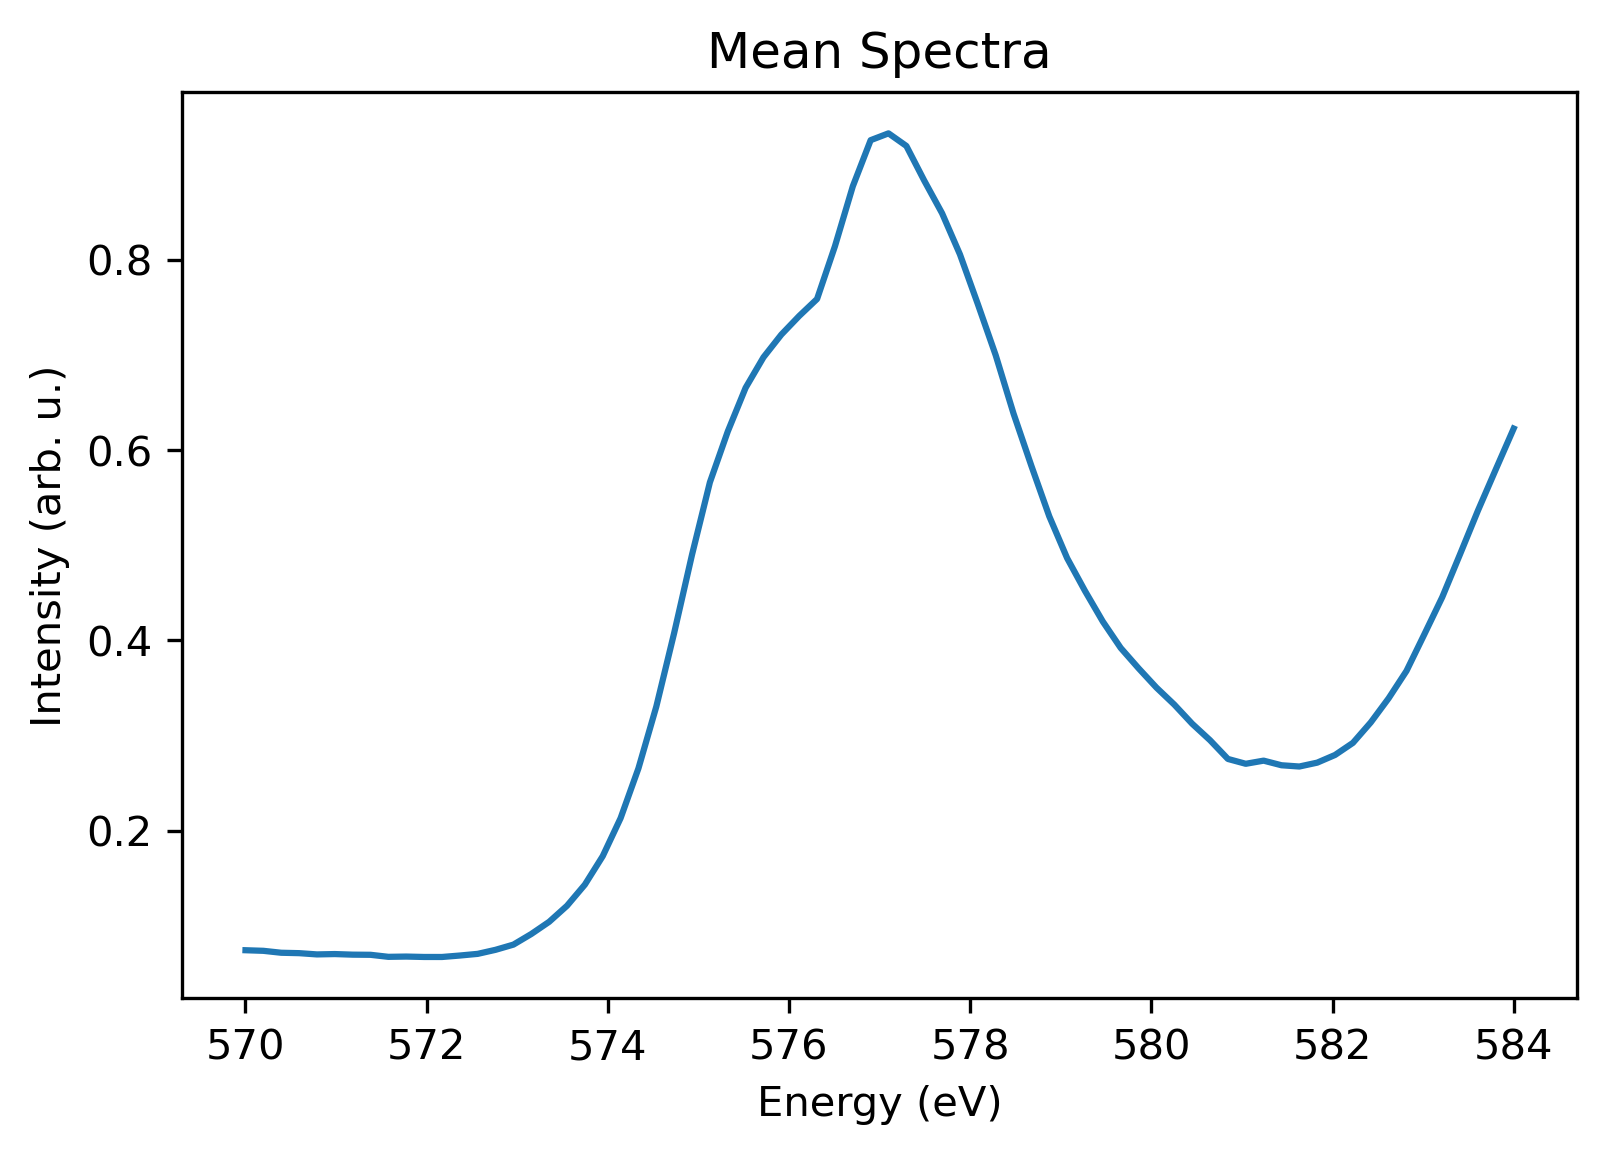

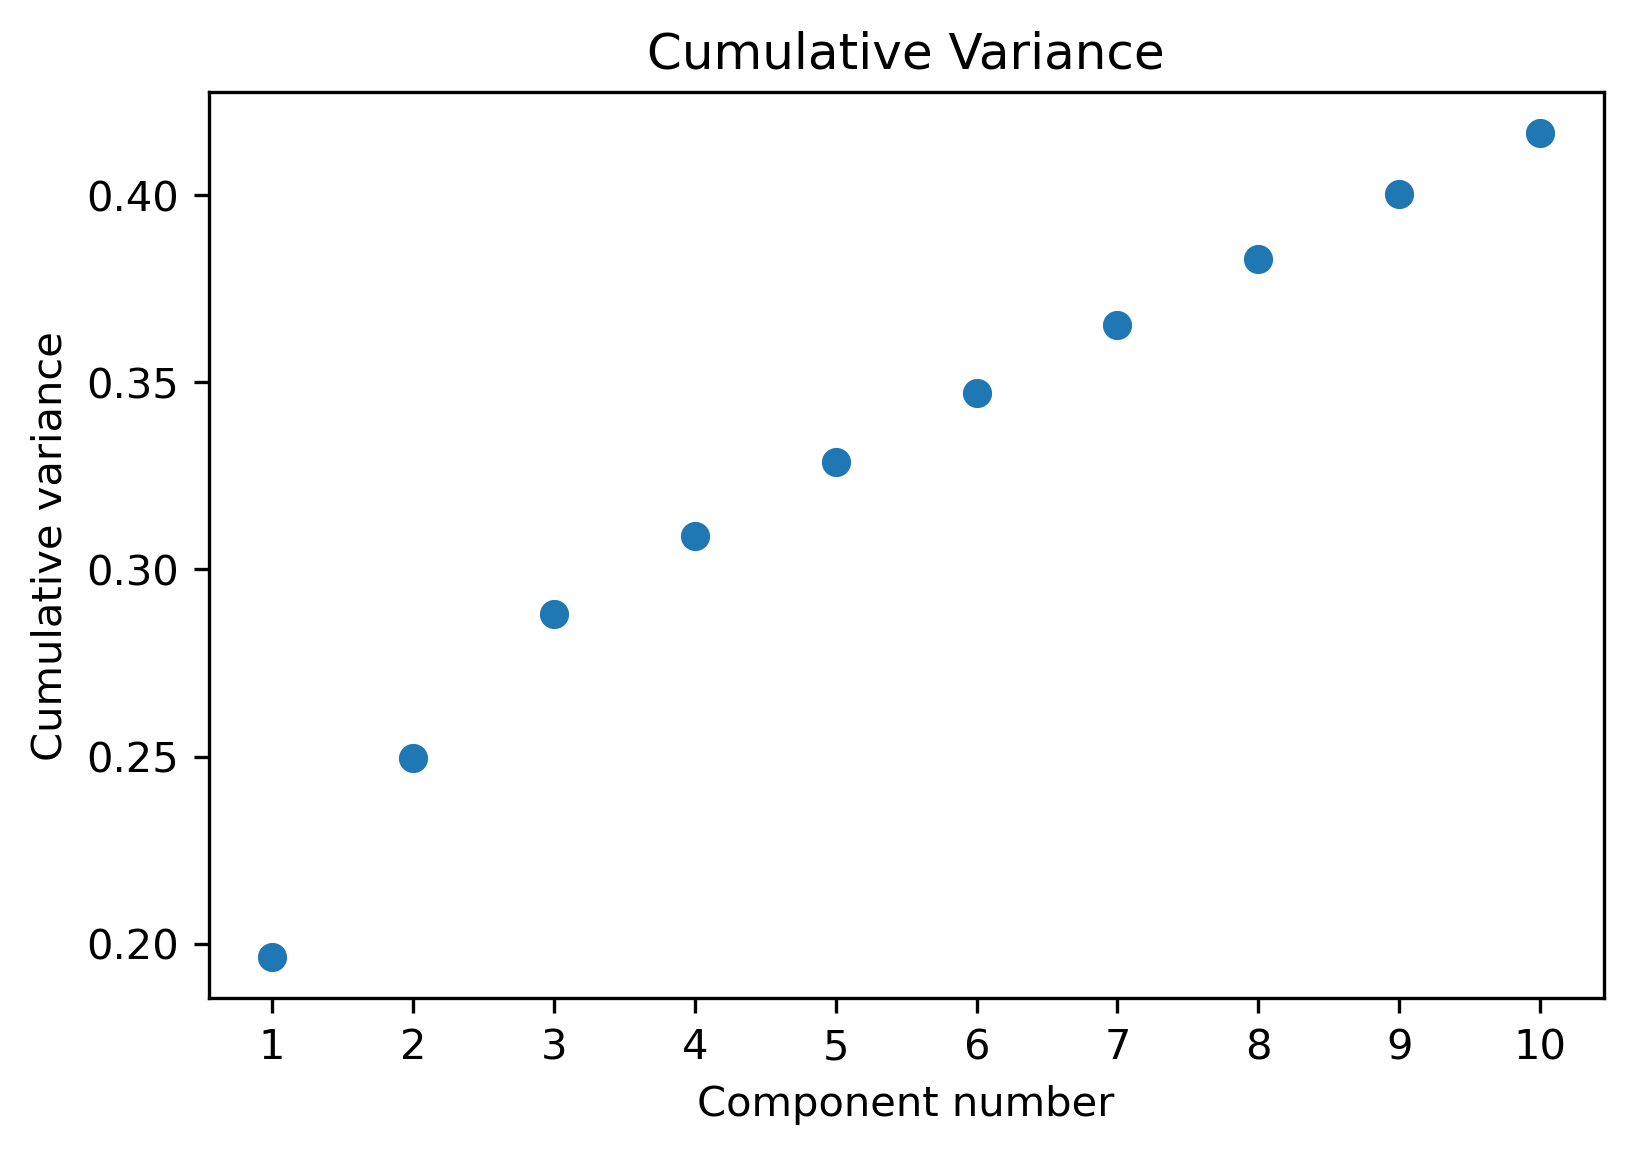

target = 0.95 of total data variance:  0.28577921497131387
Critical value:  62


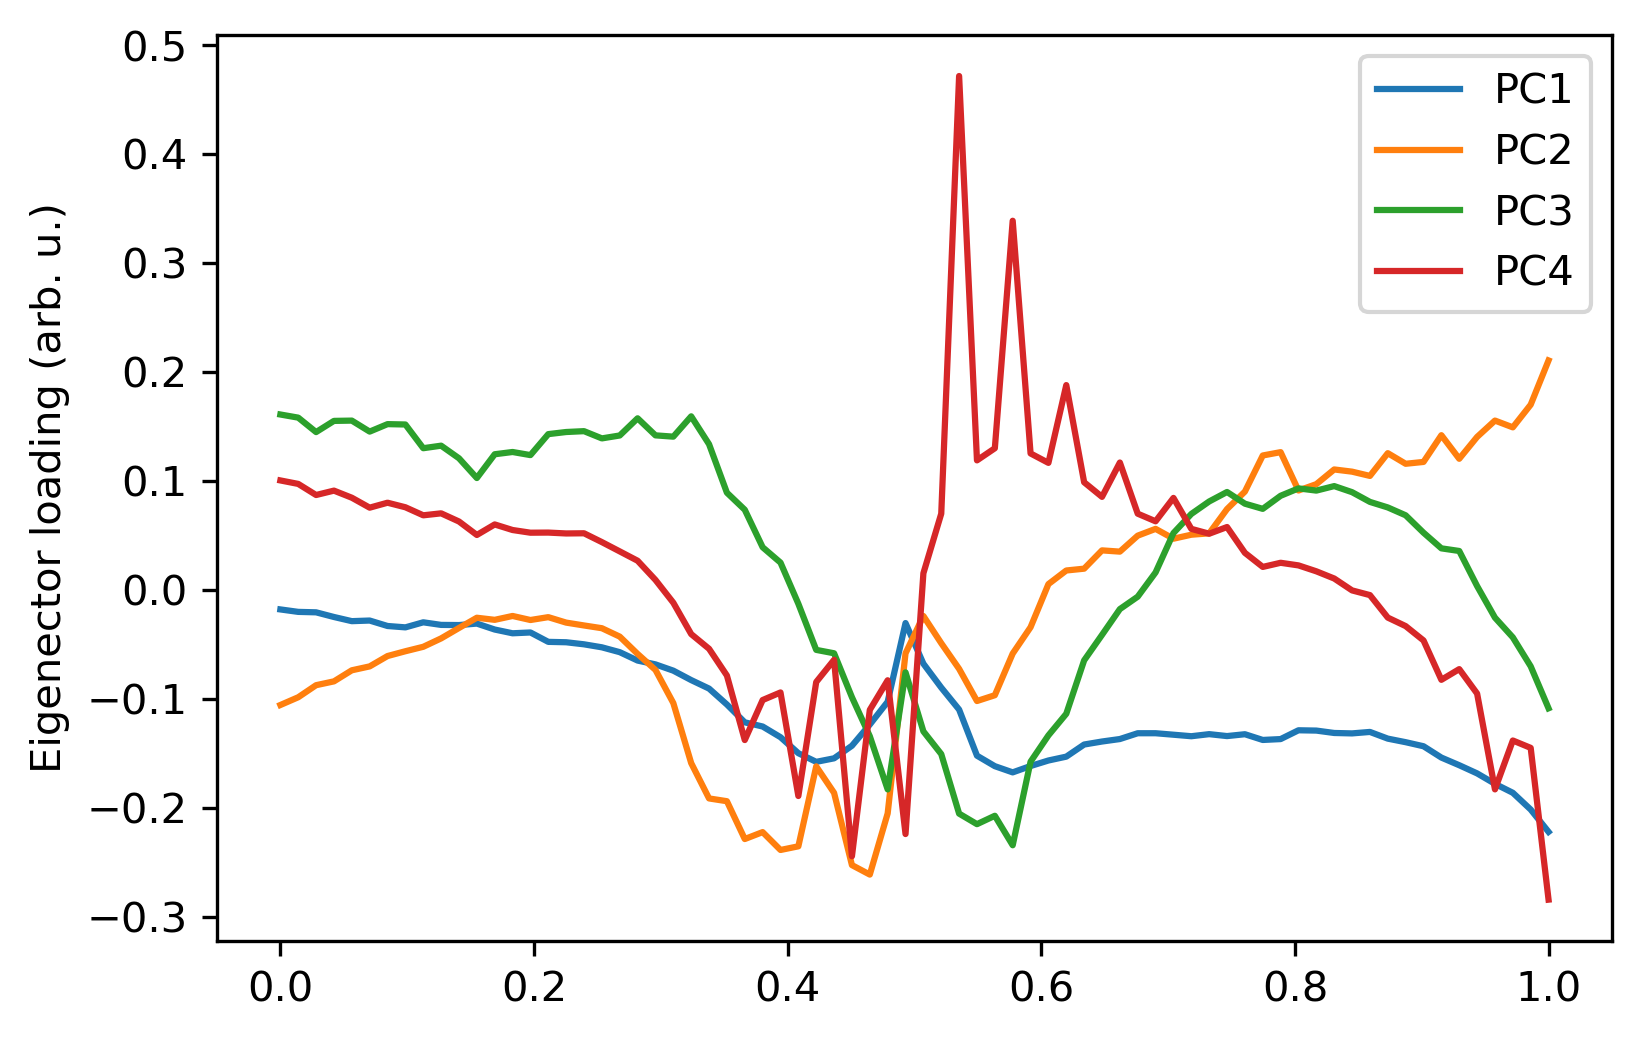

In [20]:
results = perform_pca(mo_ox2,mean_centered=False,energy_range=[570,584])
get_pca_info(results)

(87, 1024, 1024)


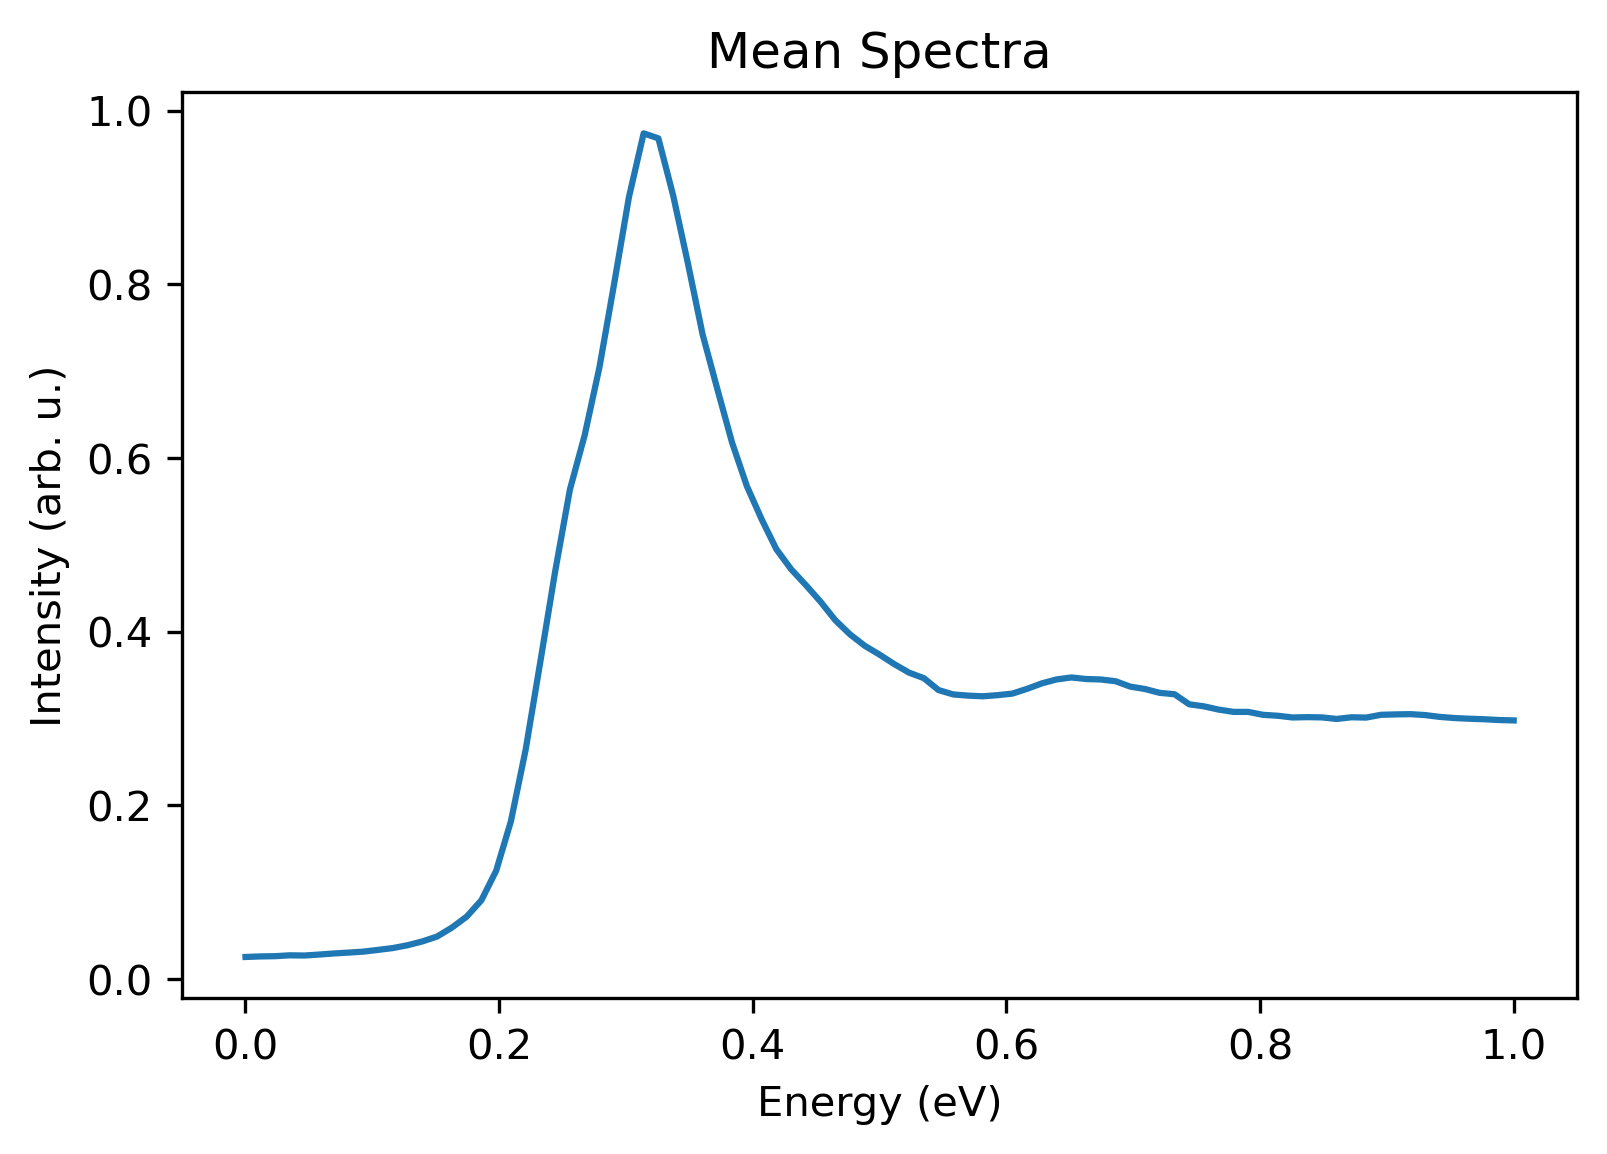

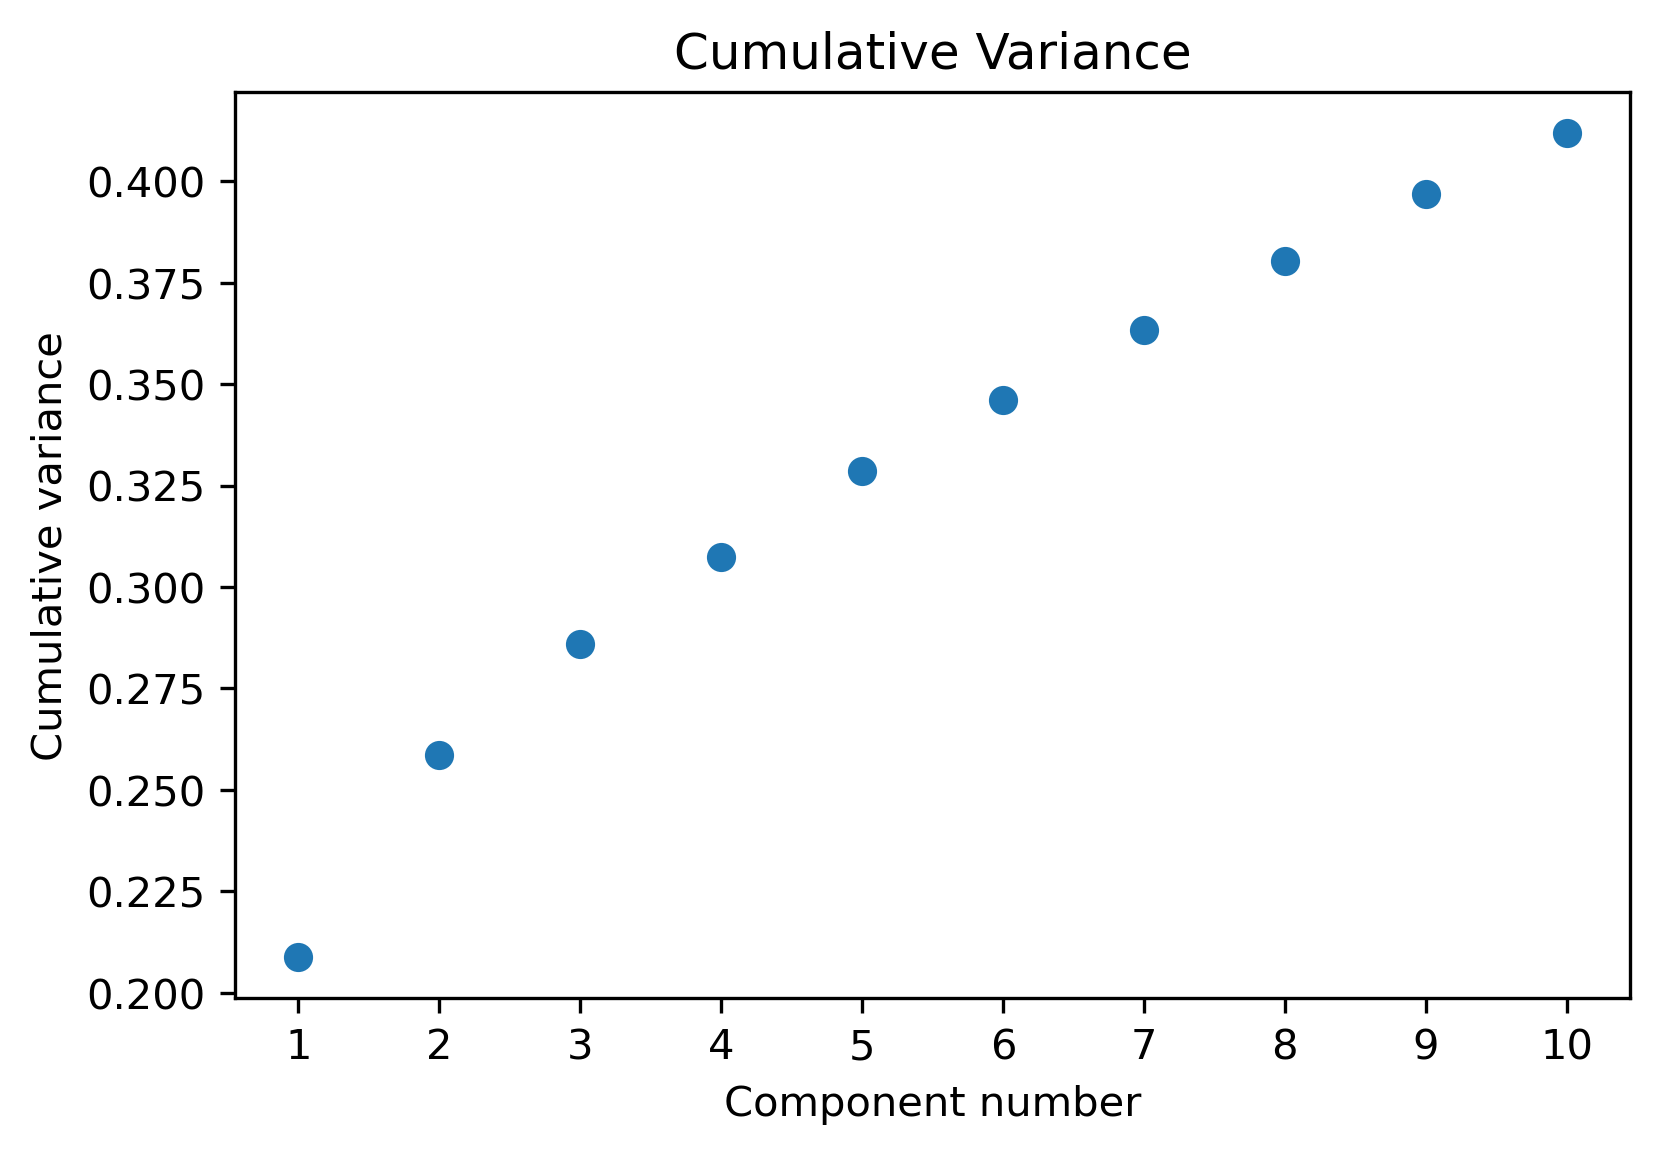

target = 0.95 of total data variance:  0.11032416262719039
Critical value:  70


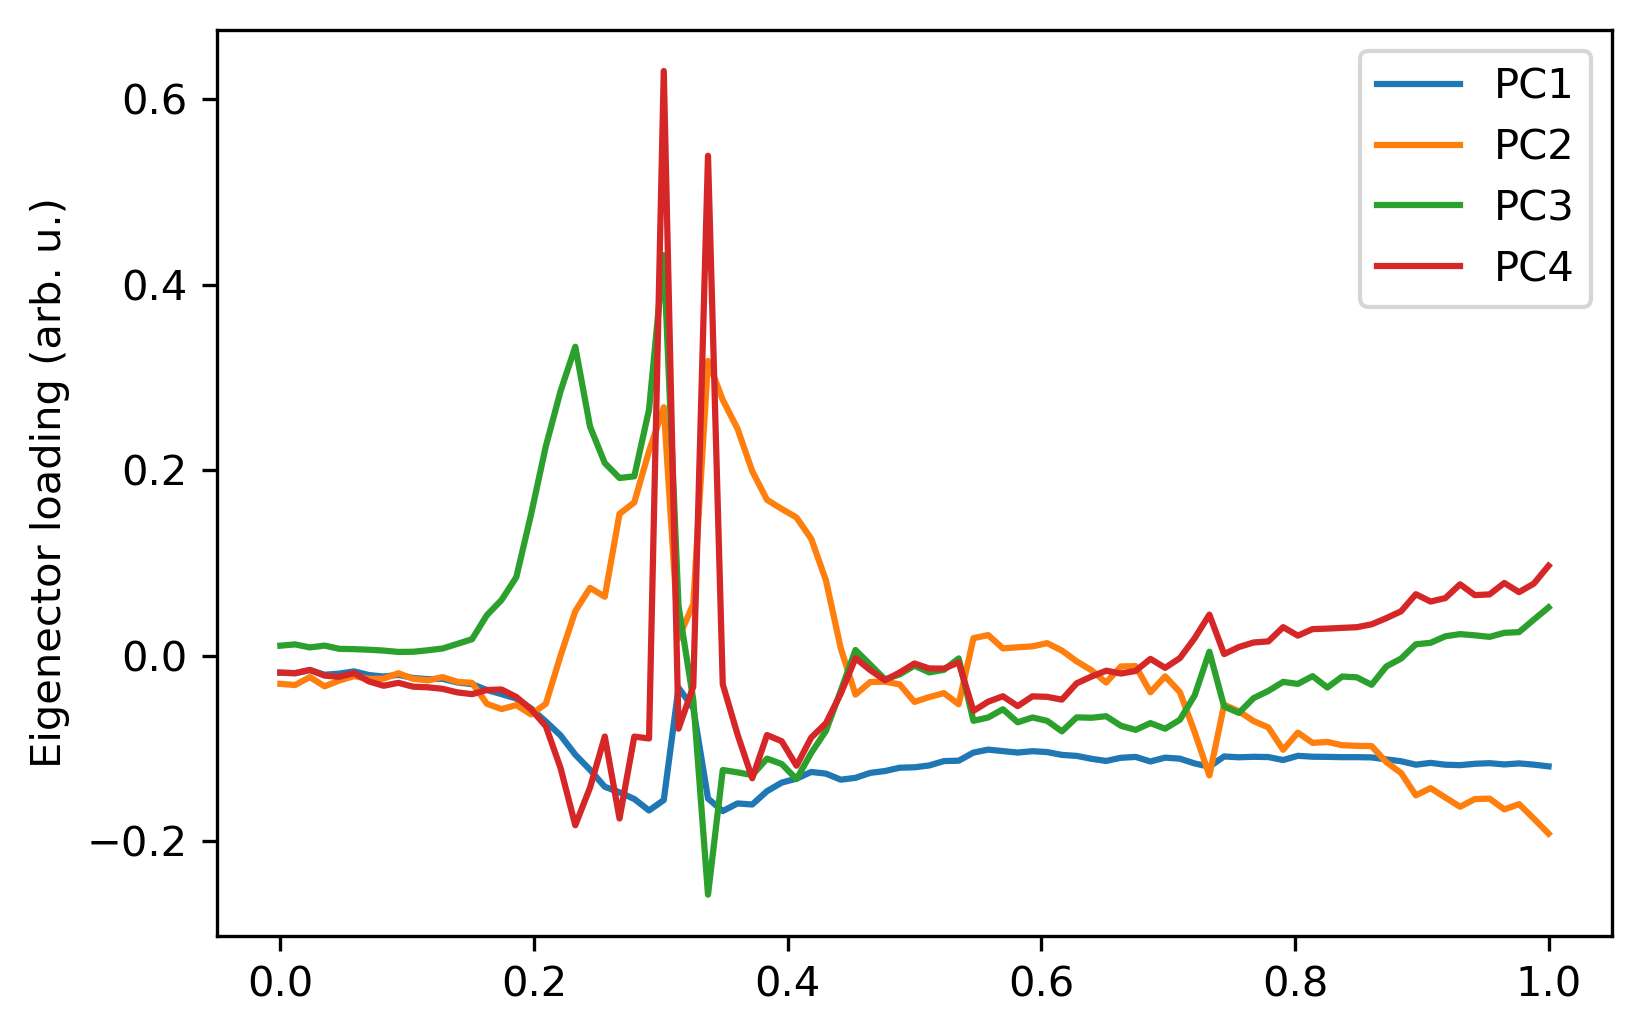

In [11]:
results = perform_pca(cr5_ox1_ni,mean_centered=False)
get_pca_info(results)

(87, 1024, 1024)


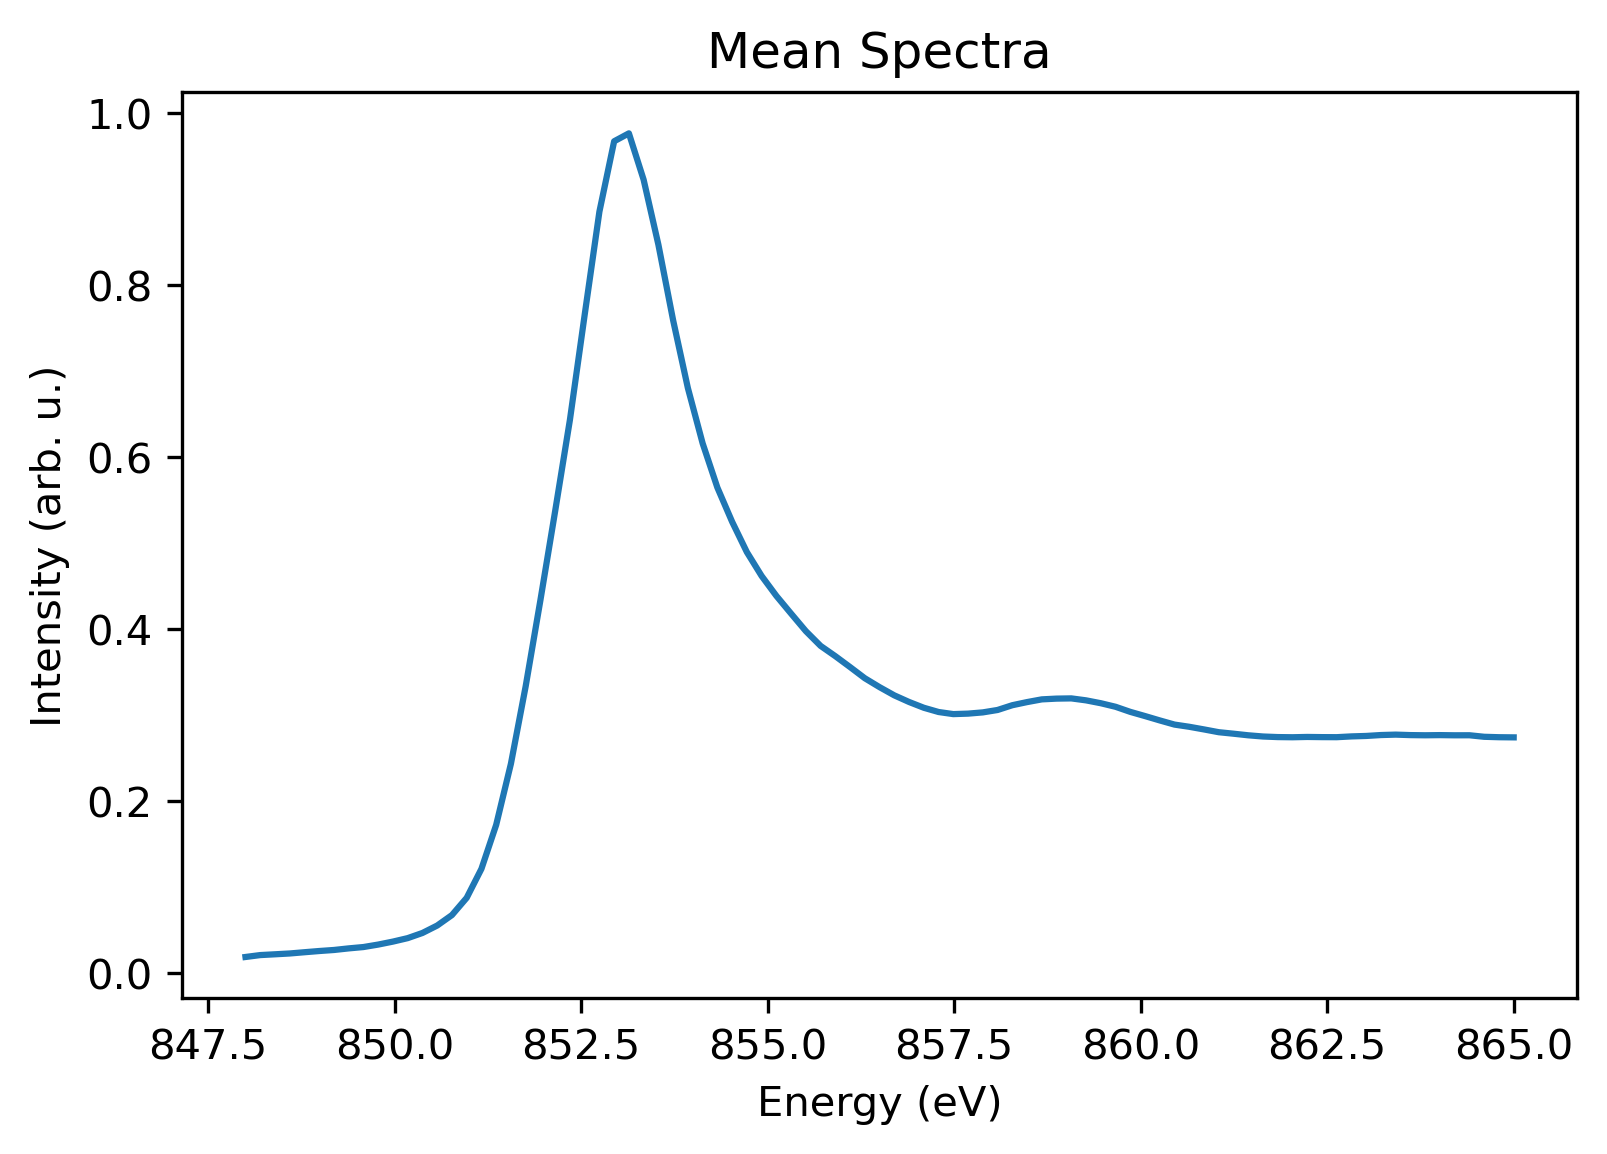

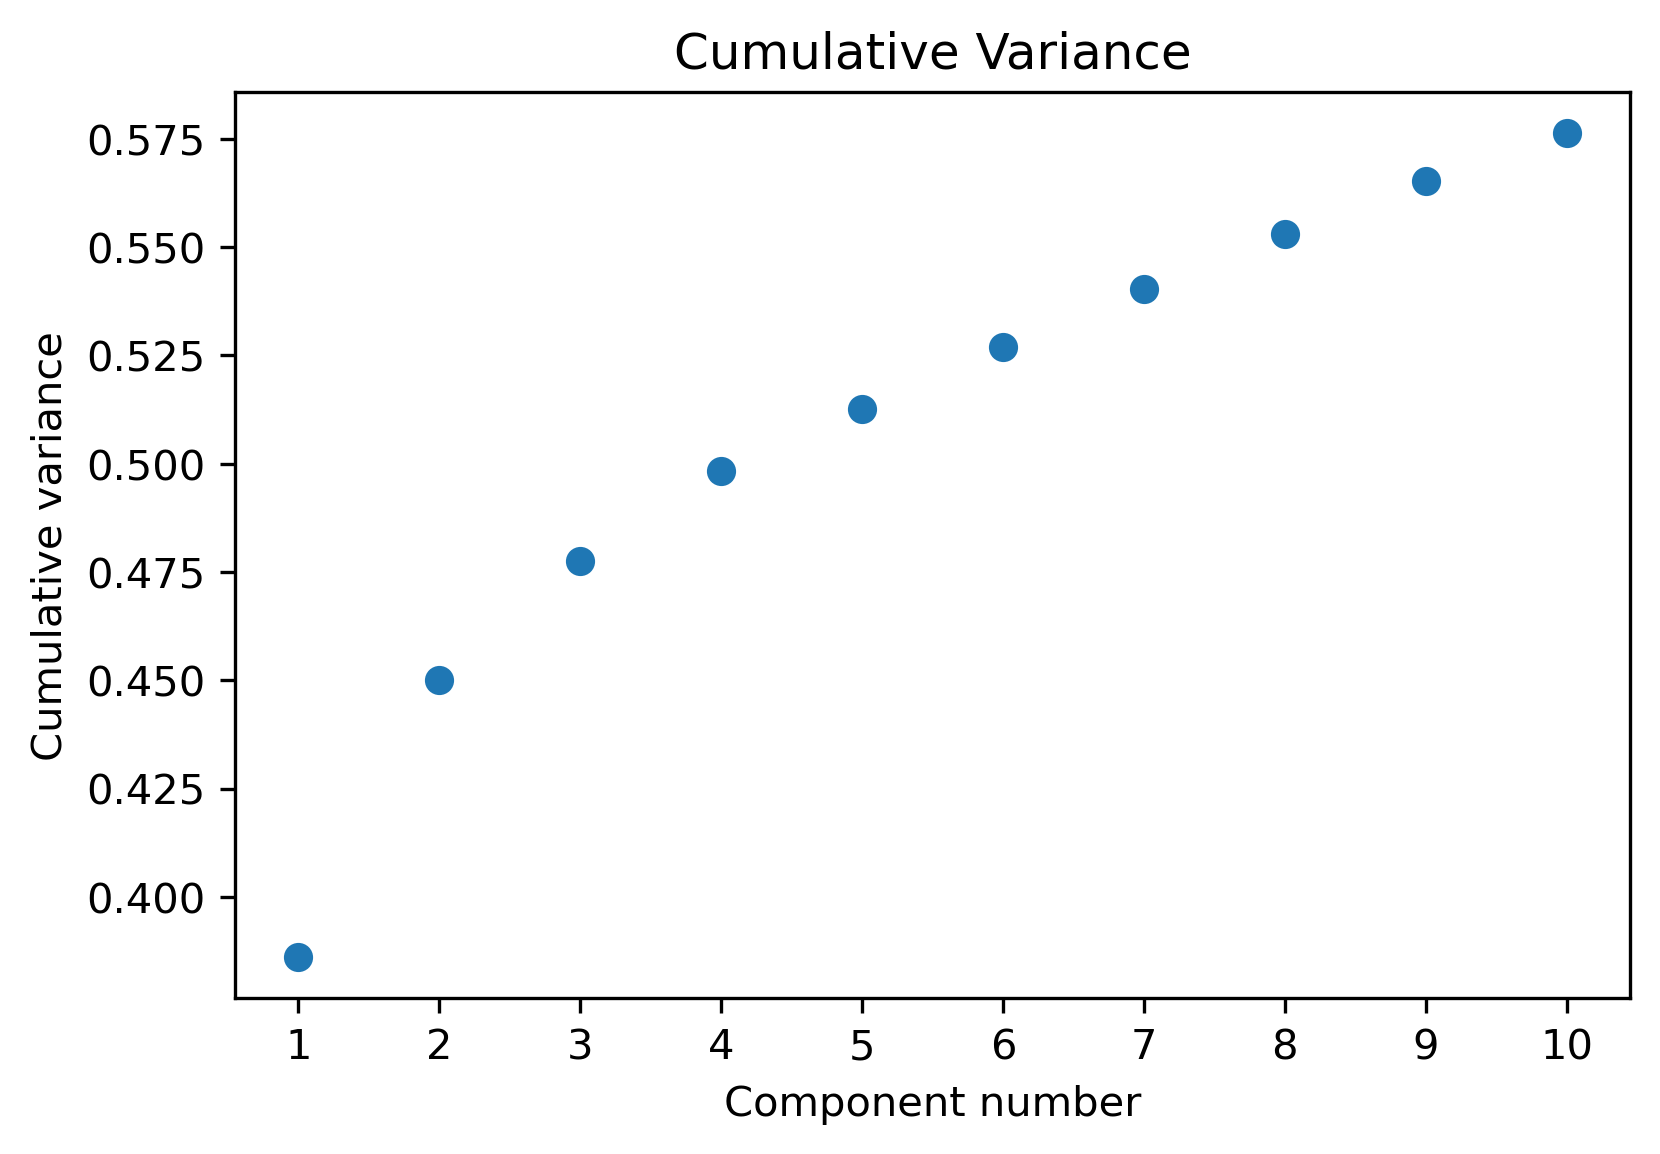

target = 0.95 of total data variance:  0.116107127697285
Critical value:  68


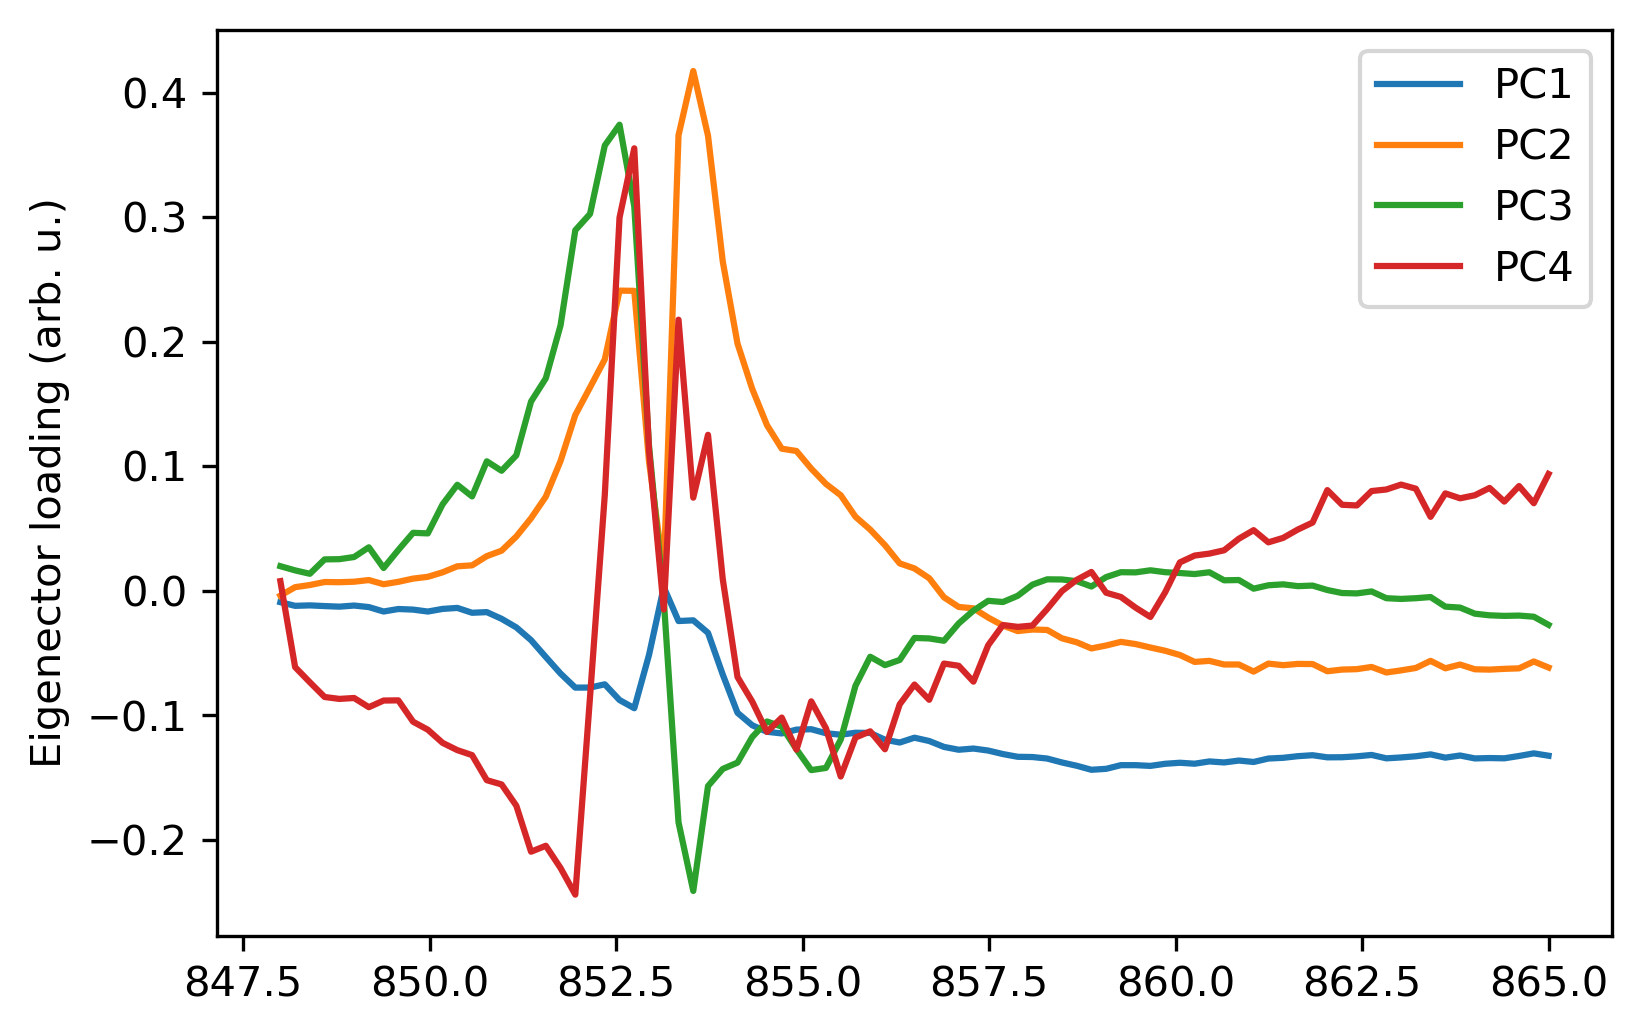

In [17]:
results = perform_pca(cr5_ox2_ni,mean_centered=False,energy_range=[848,865])
get_pca_info(results,energy_range=[848,865])

(72, 1024, 1024)


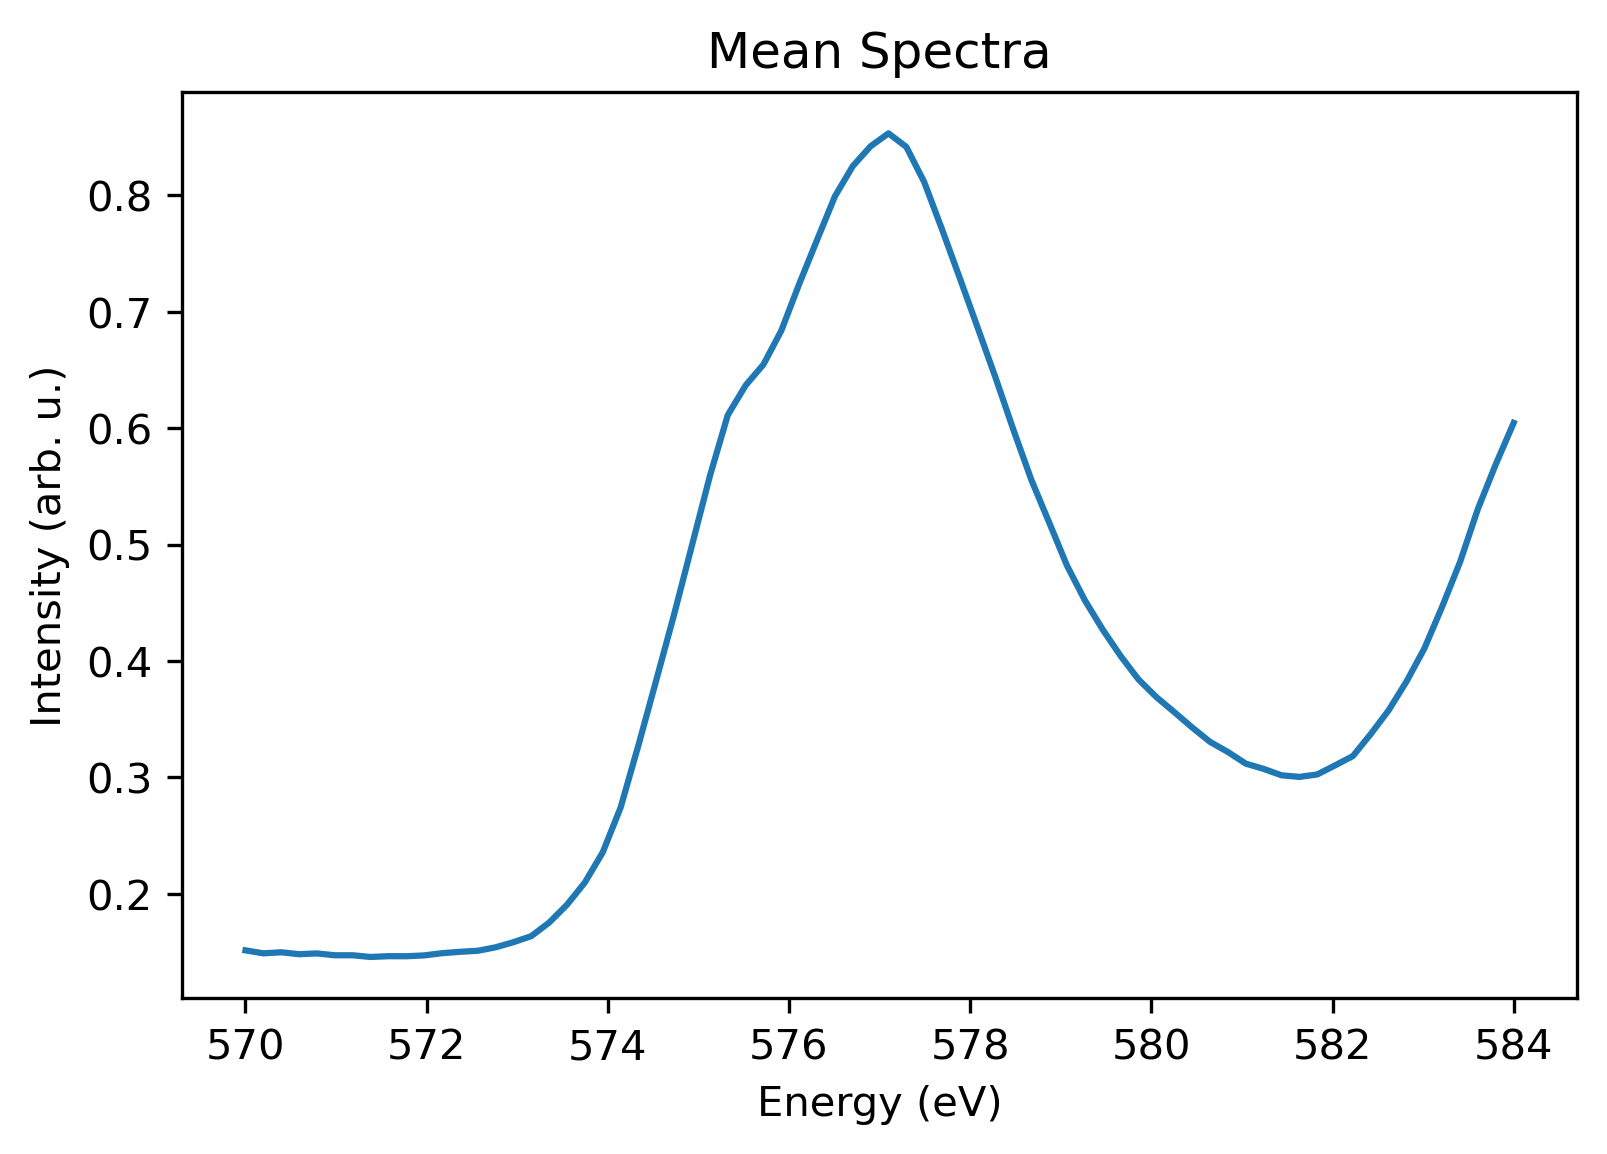

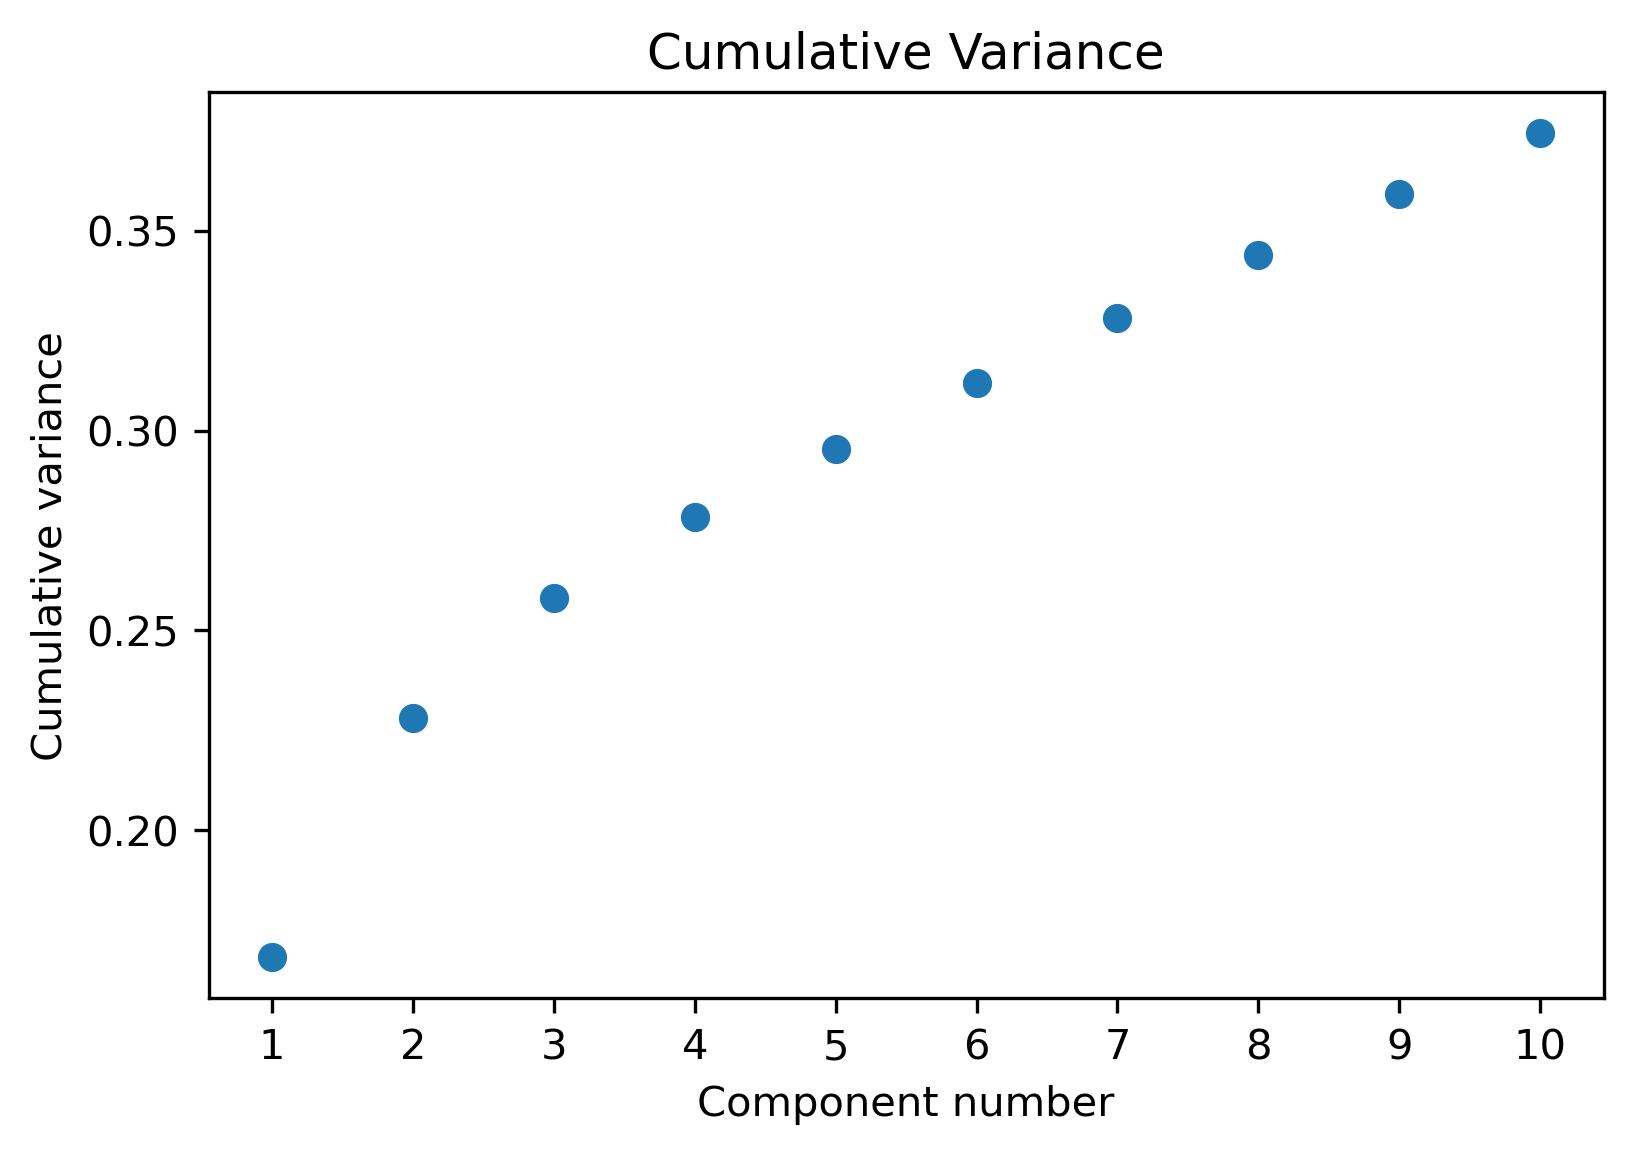

target = 0.95 of total data variance:  0.9299866072874877
Critical value:  64


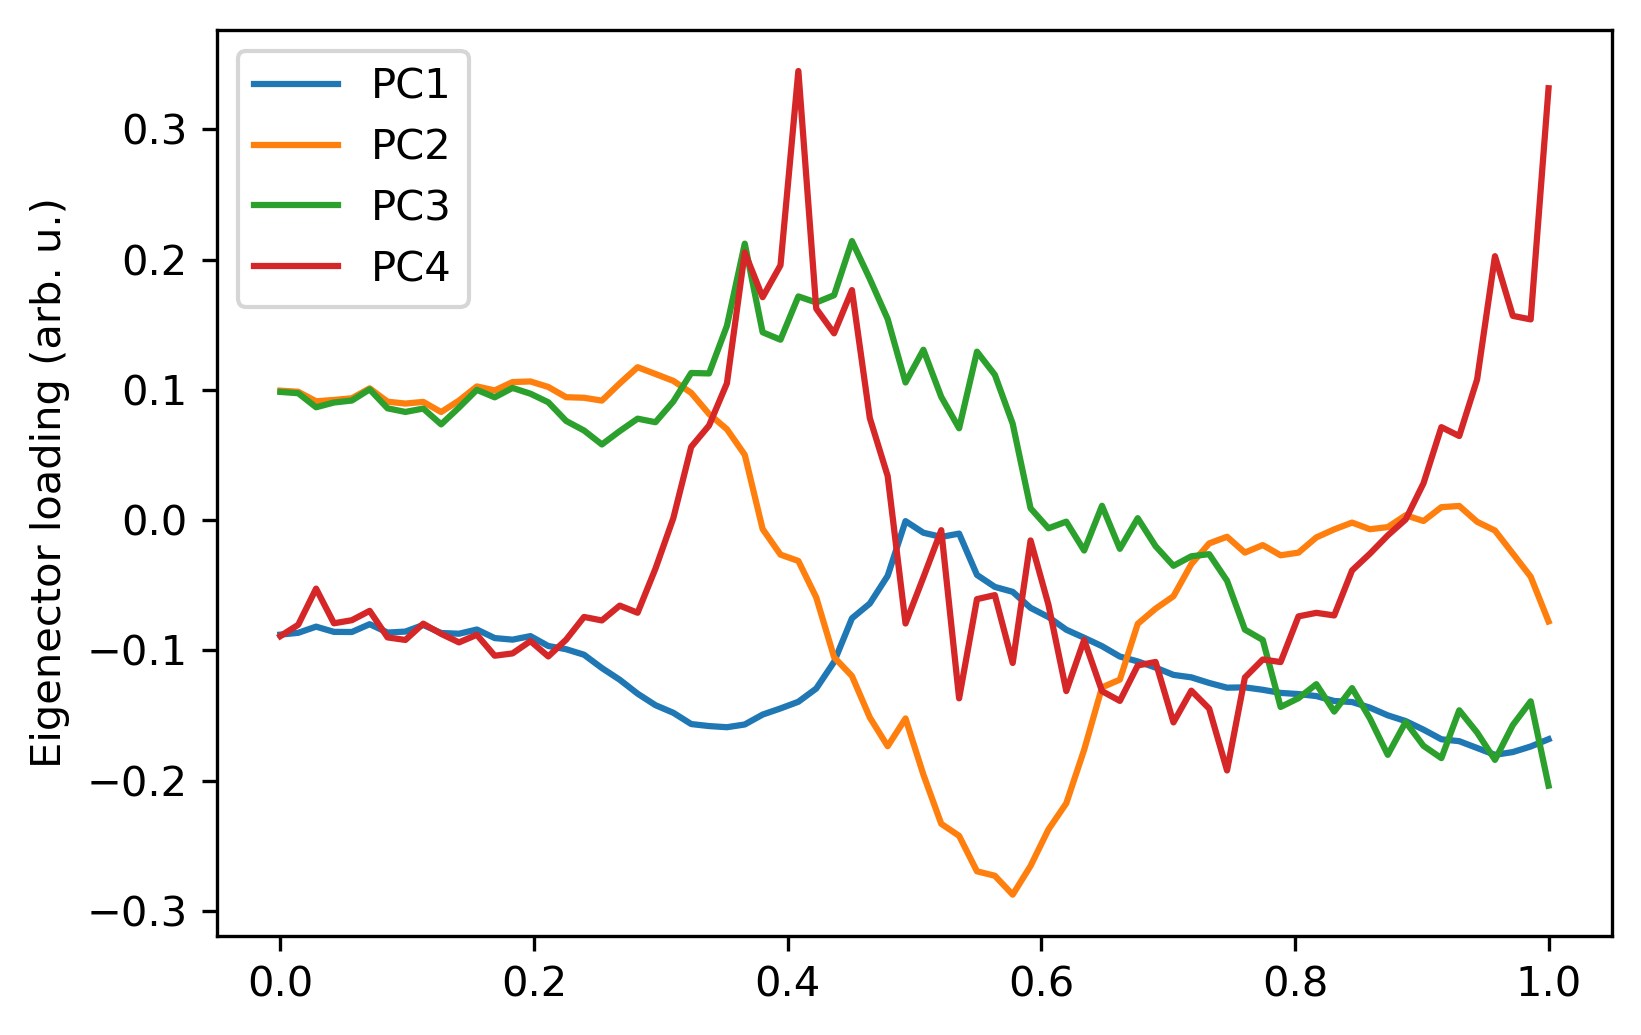

In [16]:
results = perform_pca(cr5_ox2_cr,mean_centered=False,energy_range=[570,584])
get_pca_info(results)

(28, 1024, 1024)


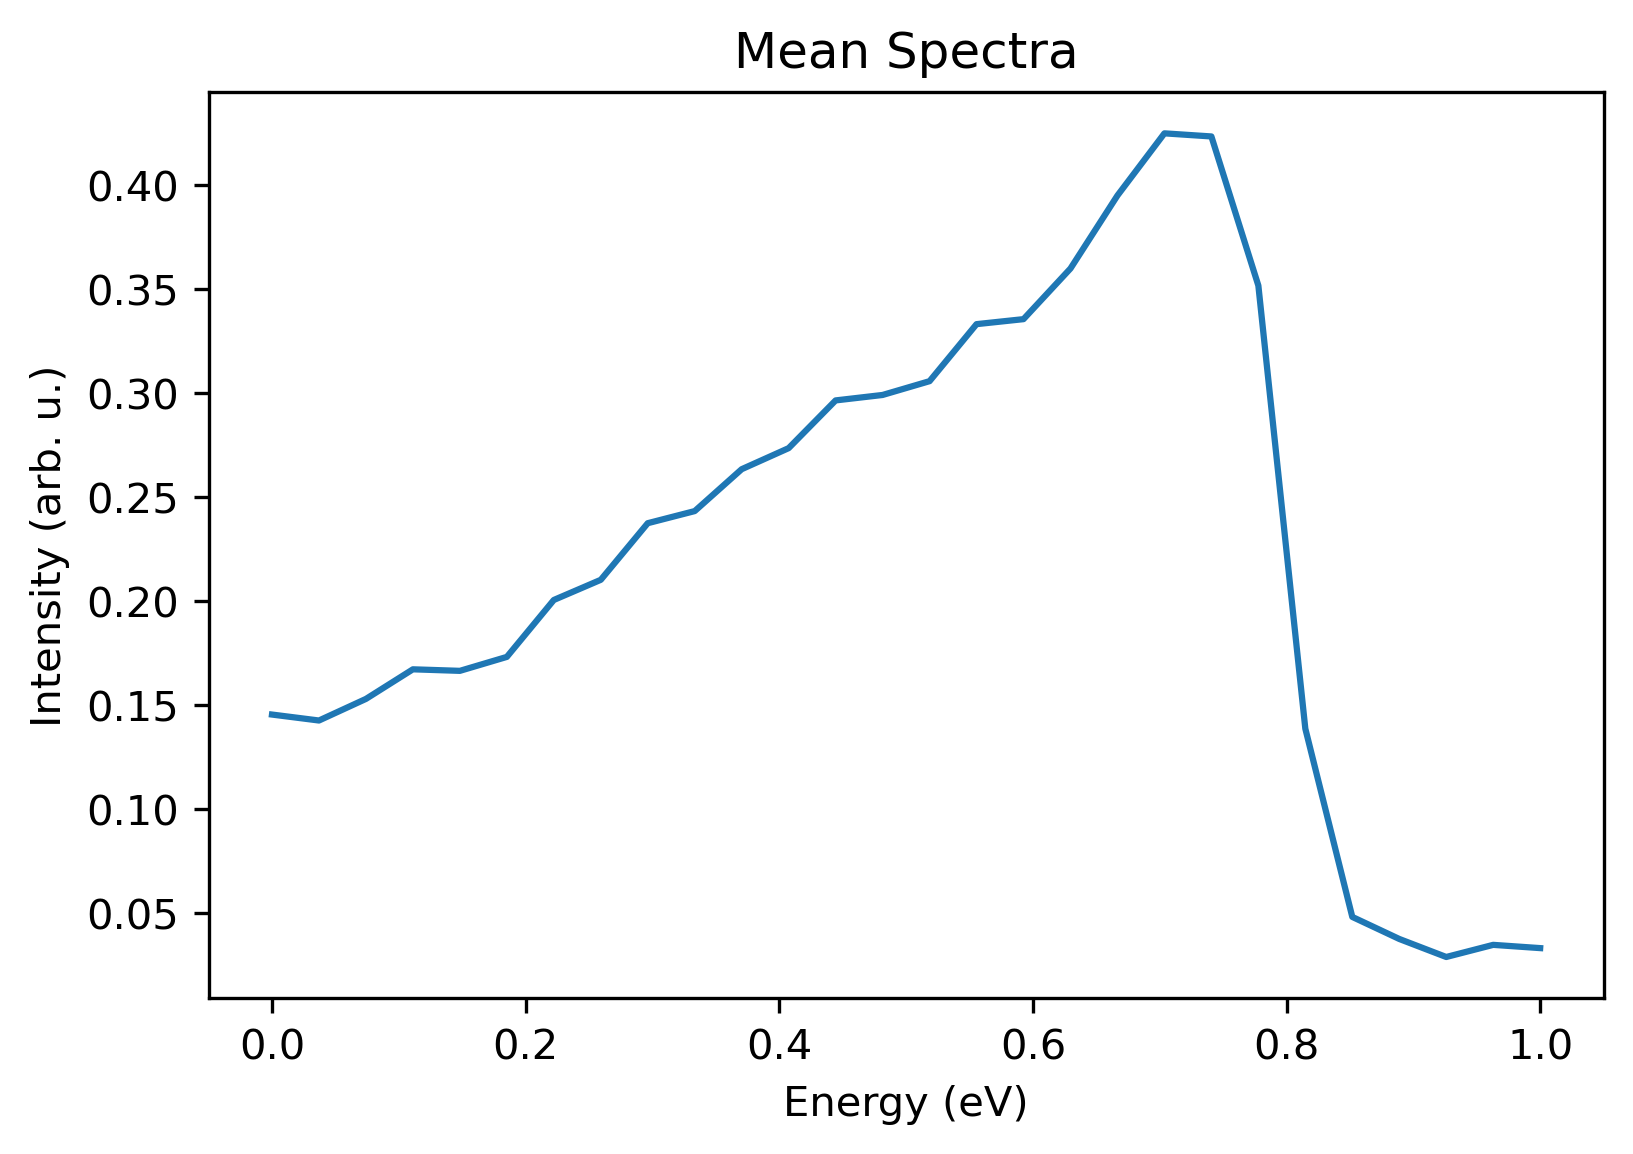

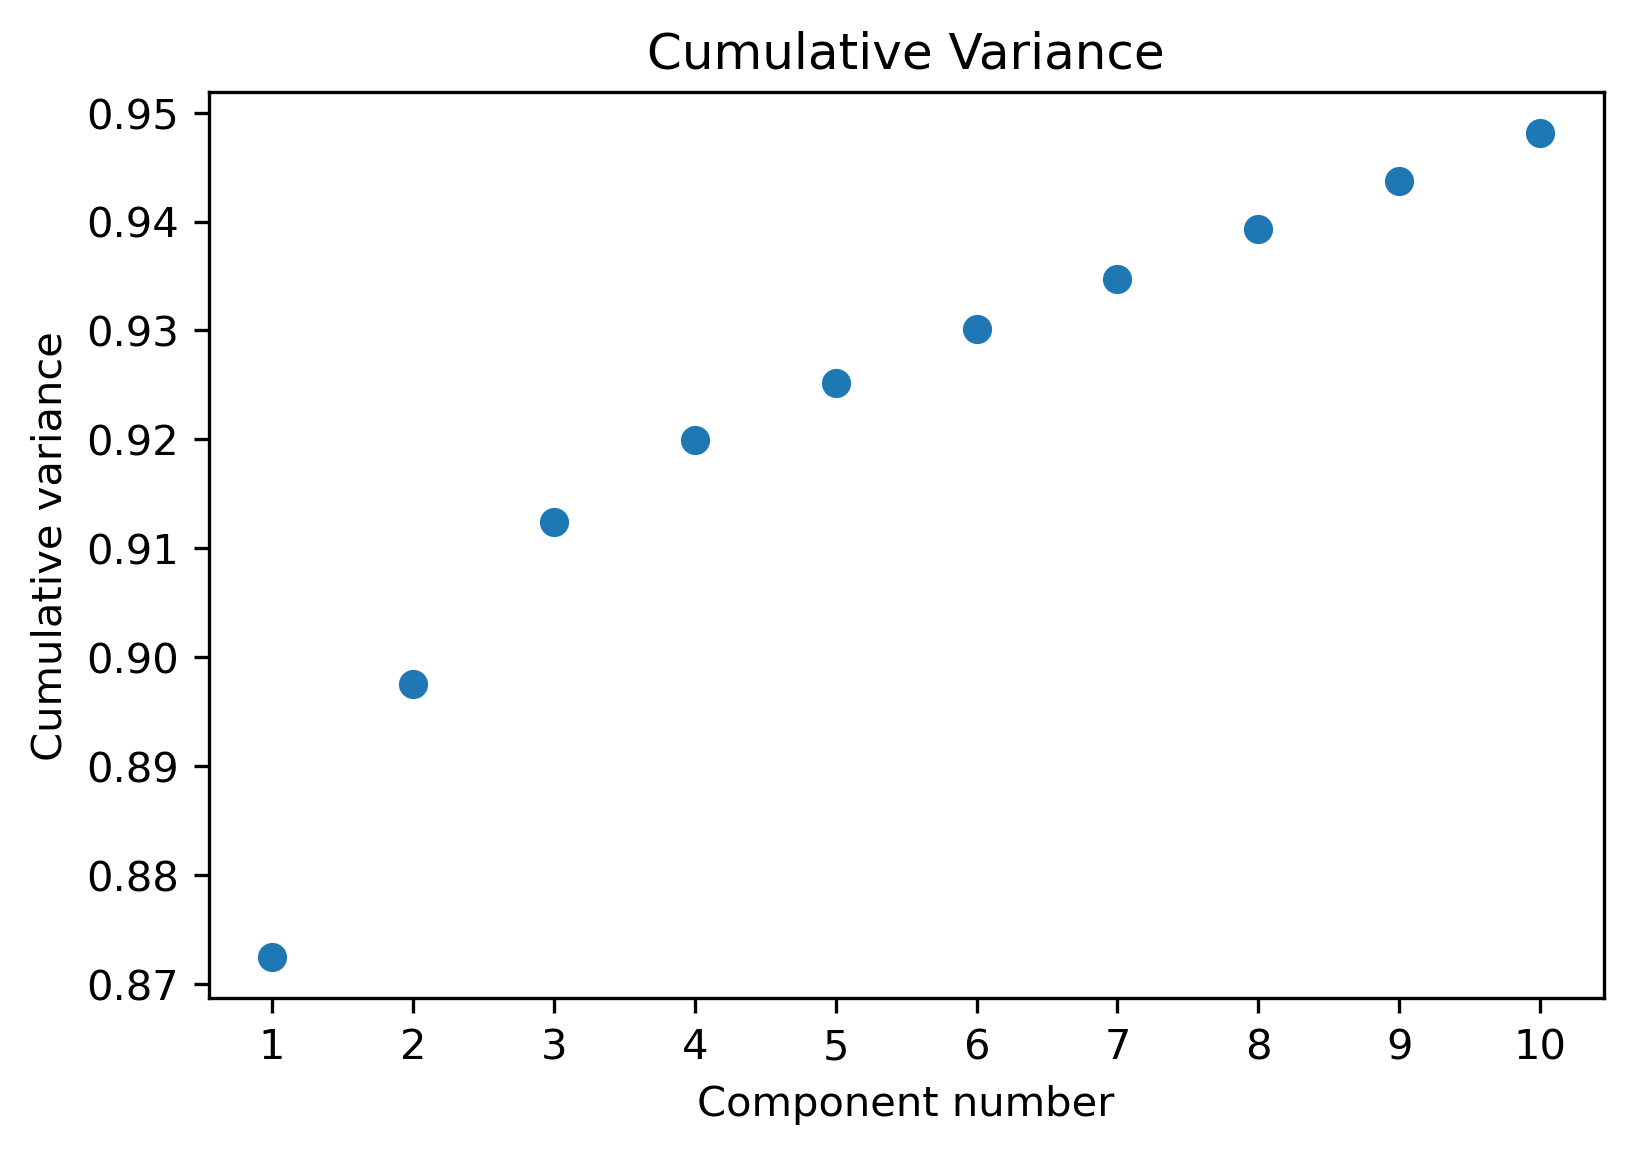

target = 0.95 of total data variance:  2.030741937373702
Critical value:  10


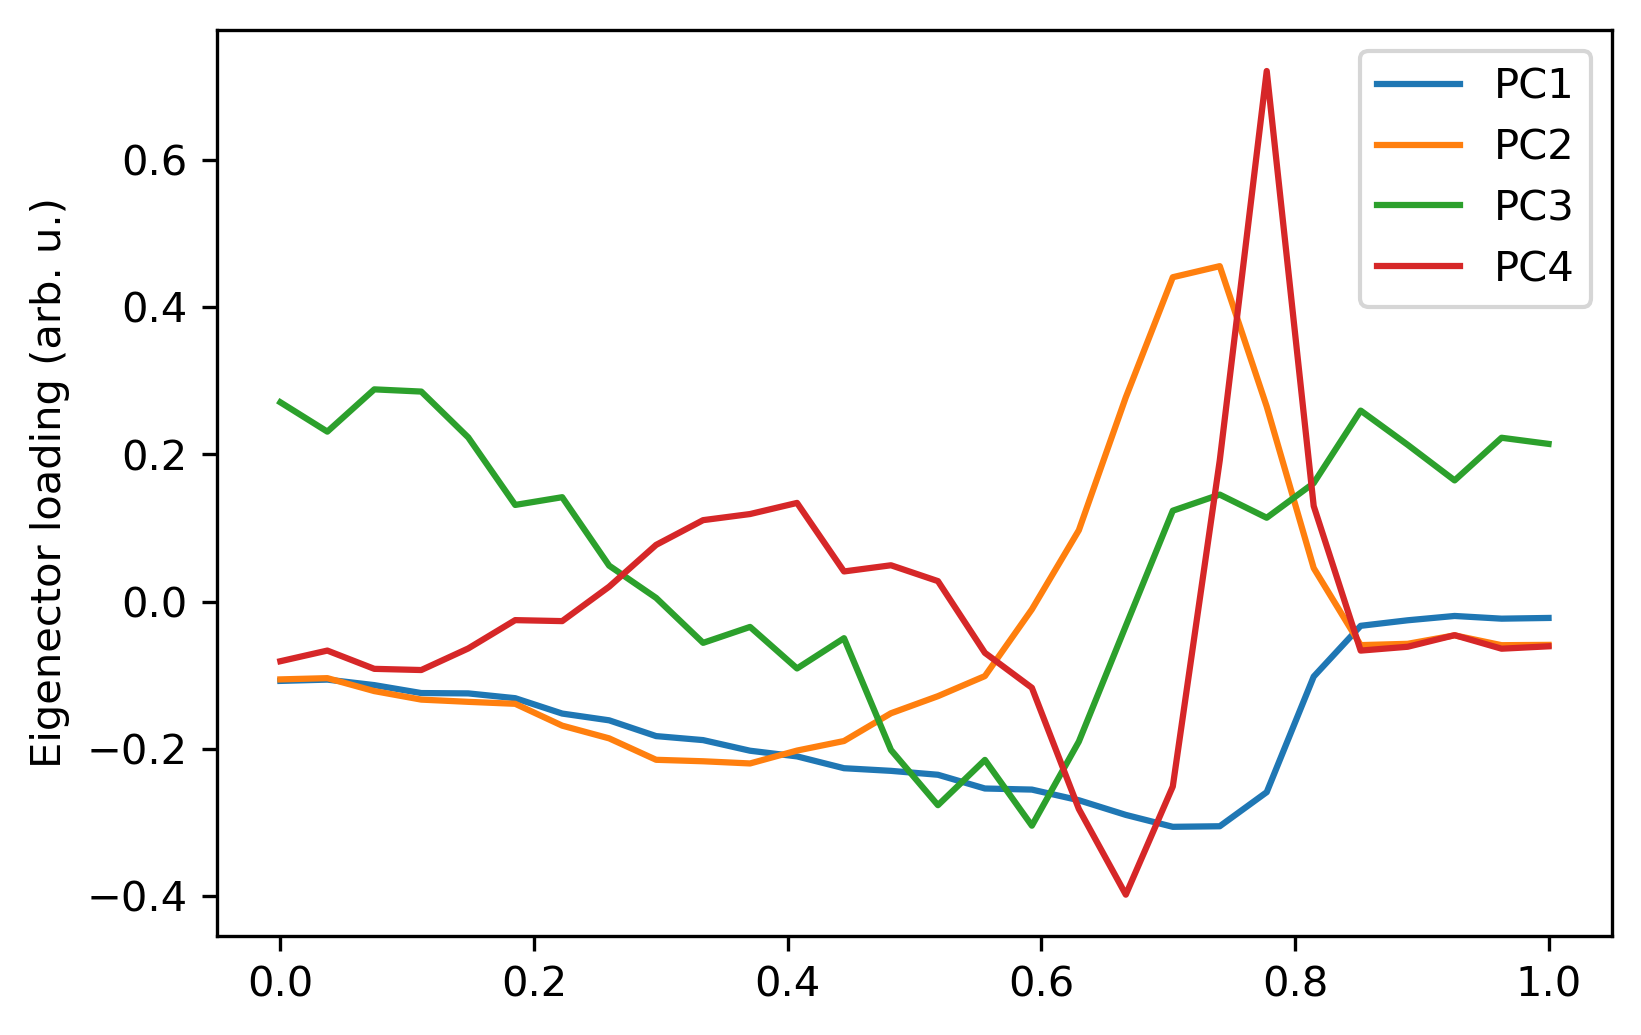

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(1048576, 4)
0


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2
3


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [10]:
vb_15L = '/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/2nd_oxidation _15L/normed_15L-VBPEEM91eVto96p4@0p2eVstep-hn100eV.tif'
results = perform_pca(vb_15L,mean_centered=True)
get_pca_info(results)
get_pca_score_image(vb_15L,results[0],num_components=4,imprefix="vb_15L")

(101, 512, 512)


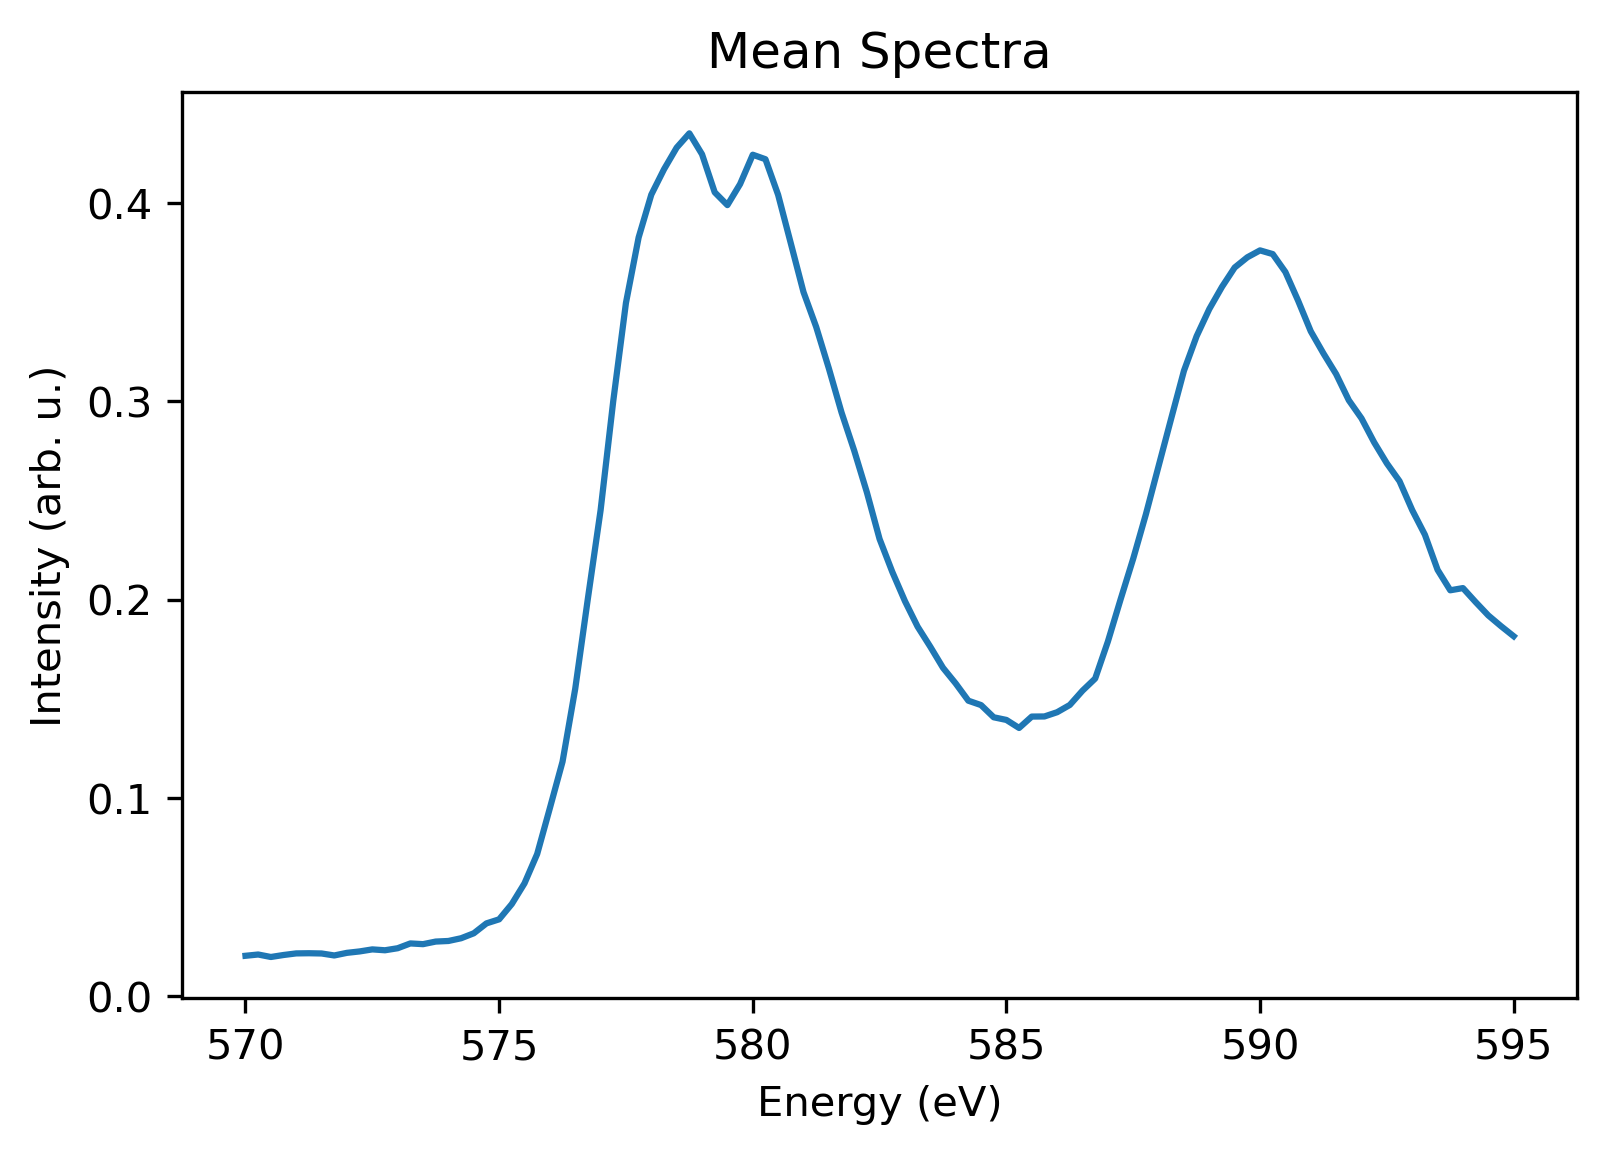

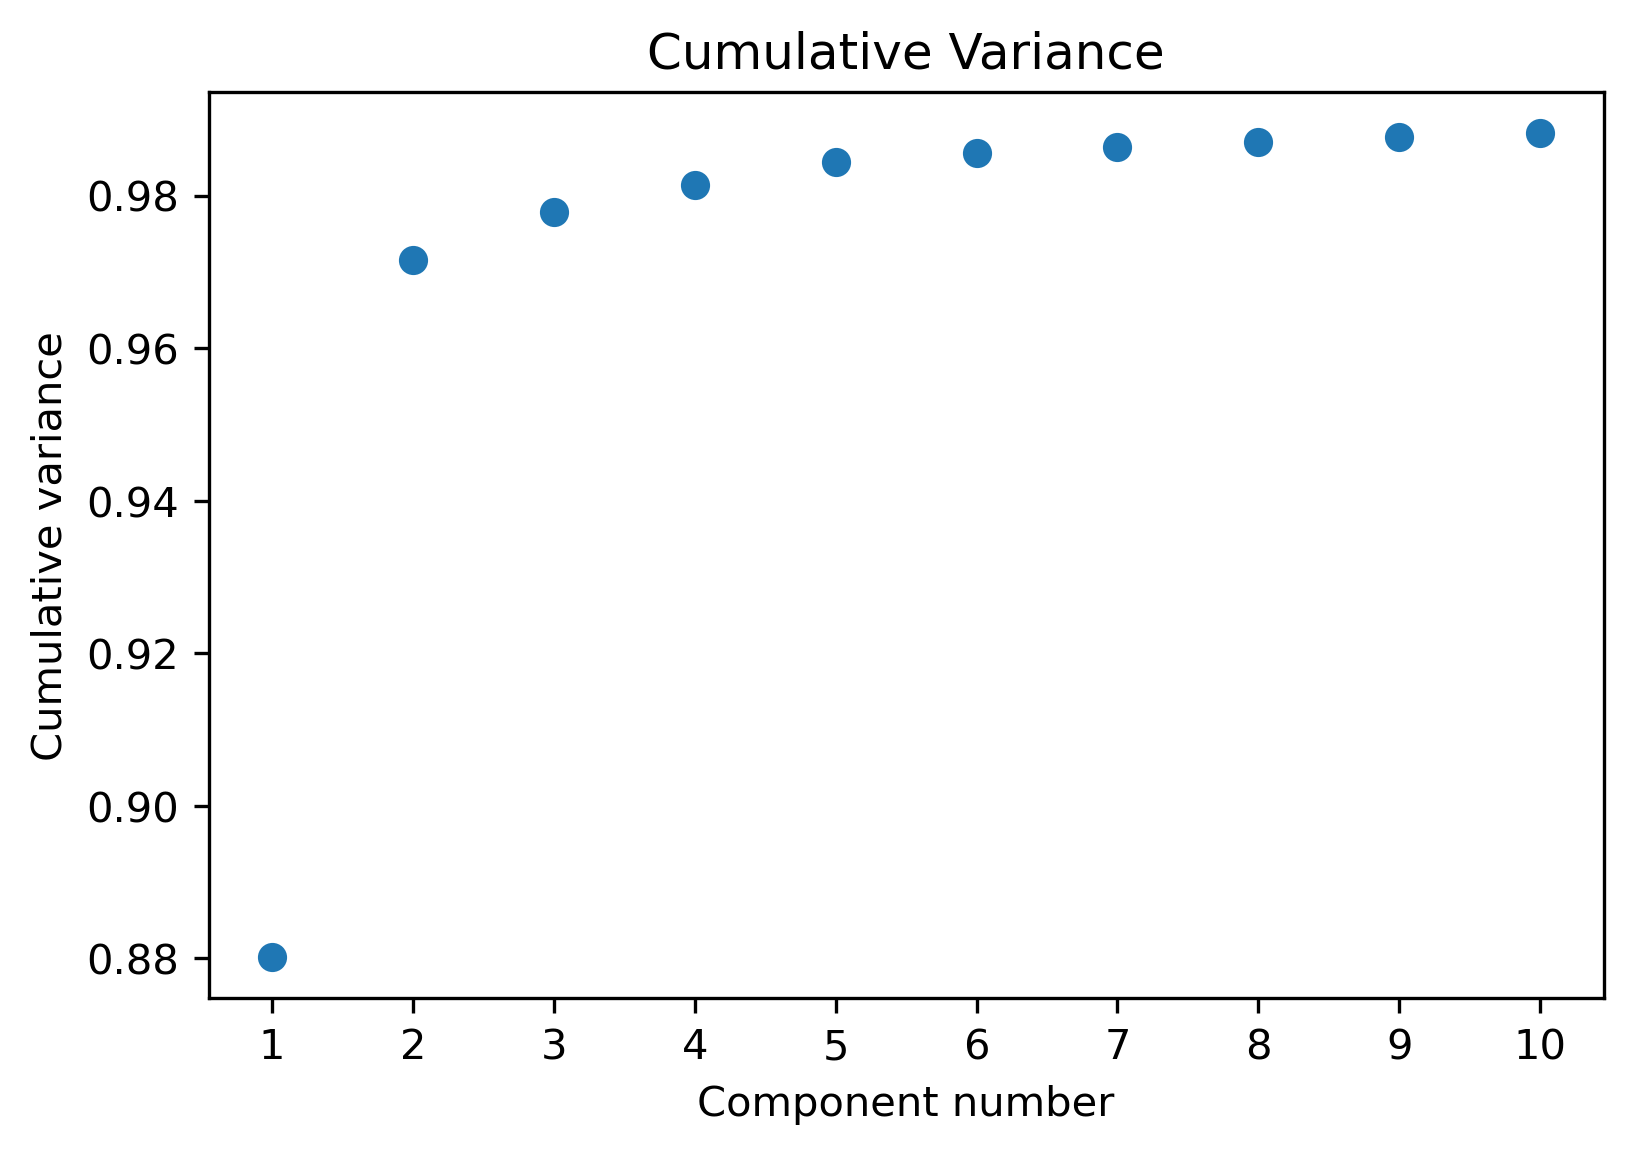

target = 0.98 of total data variance:  6.367346332199871
Critical value:  3


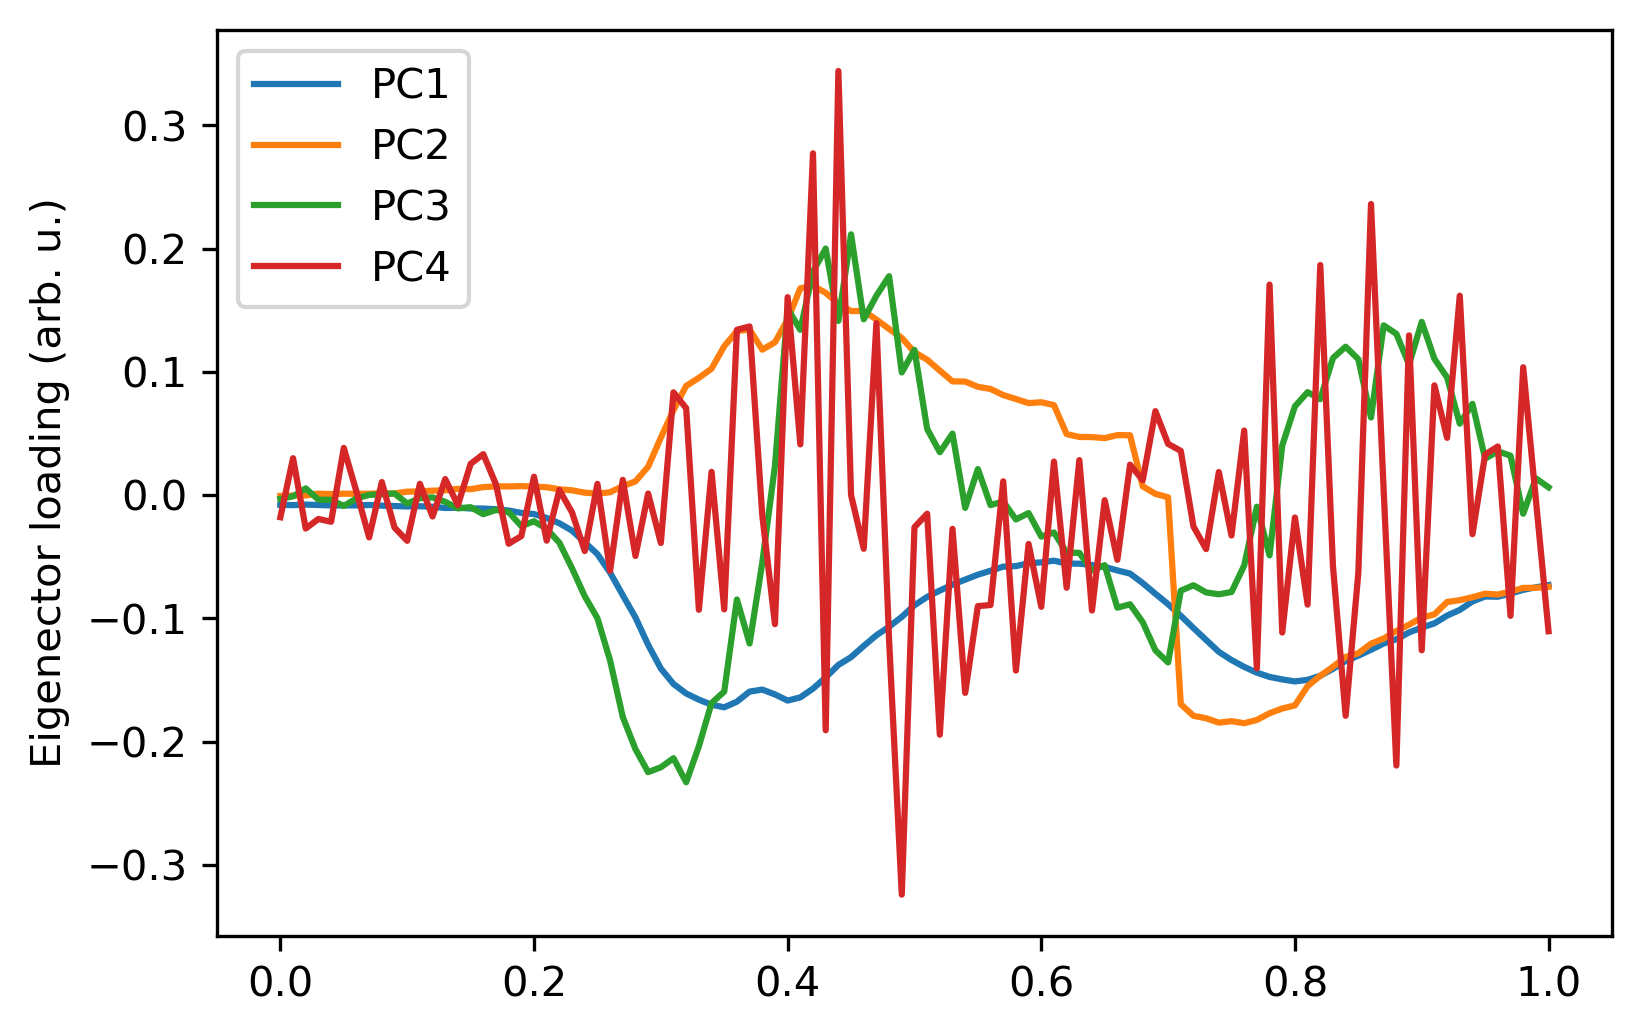

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(262144, 4)
0
1
2
3


In [14]:
cr_45L = '/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/3rd_oxidation_45L/normed_45L-Cr XAS 570-595 step0p2.tif'
results = perform_pca(cr_45L,energy_range=[570,595],mean_centered=False)
get_pca_info(results,target_variance=.98)
scores = get_pca_score_image(cr_45L,results[0],num_components=4,imprefix="cr_45L_uncentered")

In [ ]:
plt.plot(np.arange(570,590.1,0.2),results[0][:,4])
plt.xlabel("Photon energy (eV)")
plt.ylabel("Eigenvector loading (arb. u.)")
plt.title("PC4")

In [ ]:
from sklearn.decomposition import PCA
cuttest = imread("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/3rd_oxidation_45L/normed_45L-Cr XAS 570-595 step0p2.tif")
pca = PCA(svd_solver='full')
data = cuttest.reshape((cuttest.shape[0],cuttest.shape[1]*cuttest.shape[2])).T
pca.fit(data[:,0:70])
plt.plot(pca.explained_variance_ratio_[:20],'bo')

In [ ]:
cr_45L = '/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/3rd_oxidation_45L/normed_45L-Cr XAS 570-595 step0p2.tif'
results = perform_pca(cr_45L,energy_range=[570,590])
get_pca_info(results, max_plotted=2, target_variance=.98,energy_range = [570,590],xlabel="Energy (eV)")
get_pca_score_image(cr_45L,results[0],num_components=3,imprefix="cr_45L_crop")